### Note

Please view the [README](https://github.com/deeplearning4j/dl4j-examples/tree/overhaul_tutorials/tutorials/README.md) to learn about installing, setting up dependencies, and importing notebooks in Zeppelin

### Background

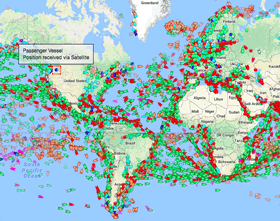
Sometimes, deep learning is just one piece of the whole project. You may have a time series problem requiring advanced analysis and you need to use more than just a neural network. Trajectory clustering can be a difficult problem to solve when your data isn't quite "even". Marine [Automatic Identification System (AIS)](https://en.wikipedia.org/wiki/Automatic_identification_system) is an open system for marine broadcasting of positions. It primarily helps collision avoidance and marine authorities to monitor marine traffic.

What if you wanted to determine the most popular routes? Or take it one step further and identify anomalous traffic? Not everything can be done with a single neural network. Furthermore, AIS data for 1 year is over 100GB compressed. You'll need more than just a desktop computer to analyze it seriously.

#### Sequence-to-sequence Autoencoders

As you learned in the *Basic Autoencoder* tutorial, applications of autoencoders in data science include dimensionality reduction and data denoising. Instead of using dense layers in an autoencoder, you can swap out simple MLPs for LSTMs. That same network using LSTMs are sequence-to-sequence autoencoders and are effective at capturing temporal structure.

In the case of AIS data, coordinates can be reported at irregular intervals over time. Not all time series for a single ship have an equal length - there's high dimensionality in the data. Before deep learning was used, other techniques like [dynamic time warping](https://en.wikipedia.org/wiki/Dynamic_time_warping) were used for measuring similarity between sequences. However, now that we can train a network to compress a **trajectory** of a ship using a seq2seq autoencoder, we can use the output for various things.
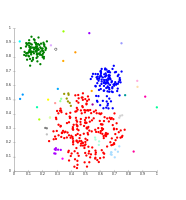
#### Introducing G-means clustering

So let's say we want to group similar trajectories of ships together using all available AIS data. It's hard to guess how many unique groups of routes exist for marine traffic, so a clustering algorithm like k-means is not useful. This is where the G-means algorithm has some utility.

G-means will repeatedly test a group for Gaussian patterns. If the group tests positive, then it will split the group. This will continue to happen until the groups no longer appear Gaussian. There are also other methods for non-K-means analysis, but G-means is quite useful for our needs.

#### Apache Spark

Sometimes a single computer doesn't cut it for munging your data. [Hadoop](http://hadoop.apache.org/) was originally developed for storing and processing large amounts of data; however, with times comes innovation and [Apache Spark](http://spark.apache.org/) was eventually developed for faster large-scale data processing, touting up to a 100x improvement over Hadoop. The two frameworks aren't entirely identical - Spark doesn't have its own filesystem and often uses Hadoop's HDFS.

Spark is also capable of SQL-like exploration of data with its spark-sql module. However, it is not unique in the ecosystem and other frameworks such as [Hive](https://hive.apache.org/) and [Pig](https://pig.apache.org/) have similar functionality. At the conceptual level, Hive and Pig make it easy to write map-reduce programs. However, Spark has largely become the de facto standard for data analysis and Pig has recently introduced a Spark integration.

### What are we going to learn in this tutorial?

Using Deeplearning4j, DataVec, and some custom code you will learn how to cluster large amounts of AIS data. We will be using a local Spark cluster built-in to Zeppelin to execute DataVec preprocessing, train an autoencoder on the converted sequences, and finally use G-means on the compressed output and visualize the groups.

### Imports

In [4]:
import org.deeplearning4j.nn.graph.ComputationGraph
import org.deeplearning4j.nn.transferlearning.TransferLearning
import org.deeplearning4j.nn.api.OptimizationAlgorithm
import org.deeplearning4j.nn.weights.WeightInit
import org.deeplearning4j.nn.conf._
import org.deeplearning4j.nn.conf.layers._
import org.deeplearning4j.nn.conf.graph.rnn._
import org.deeplearning4j.nn.conf.inputs.InputType
import org.deeplearning4j.nn.conf.WorkspaceMode
import org.deeplearning4j.optimize.listeners.ScoreIterationListener
import org.deeplearning4j.datasets.iterator.MultipleEpochsIterator
import org.deeplearning4j.datasets.datavec.RecordReaderMultiDataSetIterator

import org.datavec.api.transform._
import org.datavec.api.transform.transform.time.StringToTimeTransform
import org.datavec.api.transform.sequence.comparator.NumericalColumnComparator
import org.datavec.api.transform.transform.string.ConcatenateStringColumns
import org.datavec.api.transform.transform.doubletransform.MinMaxNormalizer
import org.datavec.api.transform.schema.Schema
import org.datavec.api.transform.metadata.StringMetaData
import org.datavec.api.records.reader.impl.csv.CSVRecordReader
import org.datavec.api.split.FileSplit
import org.datavec.spark.storage.SparkStorageUtils
import org.datavec.spark.transform.misc.StringToWritablesFunction
import org.datavec.spark.transform.SparkTransformExecutor
import org.datavec.api.transform.condition._
import org.datavec.api.transform.condition.column._
import org.datavec.api.transform.sequence.window.ReduceSequenceByWindowTransform
import org.datavec.api.transform.reduce.Reducer
import org.datavec.api.transform.reduce.AggregableColumnReduction
import org.datavec.api.transform.sequence.window.TimeWindowFunction
import org.datavec.api.transform.ops.IAggregableReduceOp
import org.datavec.api.transform.metadata.ColumnMetaData
import org.datavec.api.writable._
import org.datavec.hadoop.records.reader.mapfile.MapFileSequenceRecordReader
import org.datavec.api.util.ArchiveUtils

import org.nd4j.linalg.api.ndarray.INDArray
import org.nd4j.linalg.dataset.api.MultiDataSetPreProcessor
import org.nd4j.linalg.dataset.api.MultiDataSet
import org.nd4j.linalg.lossfunctions.LossFunctions
import org.nd4j.linalg.activations.Activation
import org.nd4j.linalg.learning.config._
import org.nd4j.linalg.factory.Nd4j
import org.nd4j.linalg.indexing.BooleanIndexing
import org.nd4j.linalg.indexing.INDArrayIndex
import org.nd4j.linalg.indexing.NDArrayIndex._
import org.nd4j.linalg.indexing.conditions.Conditions

import org.apache.spark.api.java.function.Function
import org.apache.commons.io.FileUtils
import org.joda.time.DateTimeZone
import org.joda.time.format.DateTimeFormat

import scala.collection.JavaConversions._
import scala.collection.JavaConverters._
import scala.io.Source
import java.util.Random
import java.util.concurrent.TimeUnit
import java.io._
import java.net.URL

val cache = new File(System.getProperty("user.home"), "/.deeplearning4j")

### Download the dataset

The file we will be downloading is nearly 2GB uncompressed, make sure you have enough space on your local disk. If you want to check out the file yourself, you can download a copy from [http://blob.deeplearning4j.org/datasets/aisdk_20171001.csv.zip](http://blob.deeplearning4j.org/datasets/aisdk_20171001.csv). The code below will check if the data already exists and download the file.

In [6]:
val dataFile = new File(cache, "/aisdk_20171001.csv")

if(!dataFile.exists()) {
    val remote = "http://blob.deeplearning4j.org/datasets/aisdk_20171001.csv.zip"
    val tmpZip = new File(cache, "aisdk_20171001.csv.zip")
    tmpZip.delete() // prevents errors
    println("Downloading file...")
    FileUtils.copyURLToFile(new URL(remote), tmpZip)
    println("Decompressing file...")
    ArchiveUtils.unzipFileTo(tmpZip.getAbsolutePath(), cache.getAbsolutePath())
    tmpZip.delete()
    println("Done.")
} else {
    println("File already exists.")
}

### Examine sequence lengths

The trouble with raw data is that it usually doesn't have the clean structure that you would expect for an example. It's useful to investigate the structure of the data, calculate some basic statistics on average sequence length, and figure out the complexity of the raw data.

Below we count the length of each sequence and plot the distribution. *You will see that this is very problematic. The longest sequence in the data is 36,958 time steps!*

In [8]:
val raw = sqlContext.read
    .format("com.databricks.spark.csv")
    .option("header", "true") // Use first line of all files as header
    .option("inferSchema", "true") // Automatically infer data types
    .load(dataFile.getAbsolutePath)

import org.apache.spark.sql.functions._

val positions = raw
    .withColumn("Timestamp", unix_timestamp(raw("# Timestamp"), "dd/MM/YYYY HH:mm:ss"))
    .select("Timestamp","MMSI","Longitude","Latitude")
    
positions.printSchema    
positions.registerTempTable("positions")

In [9]:
val sequences = positions
    .rdd
    .map( row => (row.getInt(1), (row.getLong(0), (row.getDouble(3), row.getDouble(2)))) ) // a tuple of ship ID and timed coordinates
    .groupBy(_._1)
    .map( group => (group._1, group._2.map(pos => pos._2).toSeq.sortBy(_._1)))
    
case class Stats(numPositions: Int, minTime: Long, maxTime: Long, totalTime: Long)

val stats = sequences
    .map { seq => 
        val timestamps = seq._2.map(_._1).toArray
        Stats(seq._2.size, timestamps.min, timestamps.max, (timestamps.max-timestamps.min))
    }
    .toDF()
stats.registerTempTable("stats")

In [10]:
%%sql

select numPositions, count(1) value
from stats 
where numPositions < 65
group by numPositions
order by numPositions

In [11]:
%%sql

select avg(totalTime), avg(minTime), avg(maxTime), avg(numPositions)
from stats

In [12]:
%%sql

select floor(Longitude/10)*10 as bin_floor, count(1) value
from positions 
group by 1
order by 1

In [13]:
%%sql

select min(Latitude), max(Latitude), min(Longitude), max(Longitude)
from positions

### Extract and transform

Now that we've examined our data, we need to extract it from the CSV and transform it into sequence data. DataVec and Spark make this easy to use for us.

Using DataVec's `Schema` class we define the schema of the data and their columns. Alternatively, if you have a sample file of the data you can also use the `InferredSchema` class. Afterwards, we can build a `TransformProcess` that removes any unwanted fields and uses a comparison of timestamps to create sequences for each unique ship in the AIS data.

Once we're certain that the schema and transformations are what we want, we can read the CSV into a [Spark RDD](http://spark.apache.org/docs/2.1.1/programming-guide.html#resilient-distributed-datasets-rdds) and execute our transformation with DataVec. First, we convert the data to a sequence with `convertToSequence()` and a numerical comparator to sort by timestamp. Then we apply a window function to each sequence to reduce those windows to a single value. This helps reduce the variability in sequence lengths, which will be problematic when we go to train our autoencoder.

If you want to use the Scala-style method of programming, you can switch back and forth between the Scala and Java APIs for the Spark RDD. Calling `.rdd` on a `JavaRDD` will return a regular `RDD` Scala class. If you prefer the Java API, call `toJavaRDD()` on a `RDD`.

#### Filtering of trajectories

To reduce the complexity of this tutorial, we will be omitting anomalous trajectories. In the analysis above you'll see that there is a significant number of trajectories with invalid positions. Latitude and longitude coordinates do not exceed the -90,90 and -180,180 ranges respectively; therefore, we filter them. Additionally, many of the trajectories only include a handful of positions - we will eliminate sequences that are too short for meaningful representation.

In [15]:
// our reduction op class that we will need shortly
// due to interpreter restrictions, we put this inside an object
object Reductions extends Serializable {
    class GeoAveragingReduction(val columnOutputName: String="AveragedLatLon", val delim: String=",") extends AggregableColumnReduction {
        
        override def reduceOp(): IAggregableReduceOp[Writable, java.util.List[Writable]] = {
            new AverageCoordinateReduceOp(delim)
        }
        
        override def getColumnsOutputName(inputName: String): java.util.List[String] = List(columnOutputName)
        
        override def getColumnOutputMetaData(newColumnName: java.util.List[String], columnInputMeta: ColumnMetaData): java.util.List[ColumnMetaData] = 
            List(new StringMetaData(columnOutputName))
        
        override def transform(inputSchema: Schema) = inputSchema
        
        override def outputColumnName: String = null
        
        override def outputColumnNames: Array[String] = new Array[String](0)
        
        override def columnNames: Array[String] = new Array[String](0)
        
        override def columnName: String = null
          
        def getInputSchema(): org.datavec.api.transform.schema.Schema = ???
        
        def setInputSchema(x$1: org.datavec.api.transform.schema.Schema): Unit = ???
    }
    
    class AverageCoordinateReduceOp(val delim: String) extends IAggregableReduceOp[Writable, java.util.List[Writable]] {
        final val PI_180 = Math.PI / 180.0

        var sumx = 0.0
        var sumy = 0.0
        var sumz = 0.0
        var count = 0
        
        override def combine[W <: IAggregableReduceOp[Writable, java.util.List[Writable]]](accu: W): Unit = {
          if (accu.isInstanceOf[AverageCoordinateReduceOp]) {
            val r: AverageCoordinateReduceOp =
              accu.asInstanceOf[AverageCoordinateReduceOp]
            sumx += r.sumx
            sumy += r.sumy
            sumz += r.sumz
            count += r.count
          } else {
            throw new IllegalStateException(
              "Cannot combine type of class: " + accu.getClass)
          }
        }

        override def accept(writable: Writable): Unit = {
          val str: String = writable.toString
          val split: Array[String] = str.split(delim)
          if (split.length != 2) {
            throw new IllegalStateException(
              "Could not parse lat/long string: \"" + str + "\"")
          }
          val latDeg: Double = java.lang.Double.parseDouble(split(0))
          val longDeg: Double = java.lang.Double.parseDouble(split(1))
          val lat: Double = latDeg * PI_180
          val lng: Double = longDeg * PI_180
          val x: Double = Math.cos(lat) * Math.cos(lng)
          val y: Double = Math.cos(lat) * Math.sin(lng)
          val z: Double = Math.sin(lat)
          sumx += x
          sumy += y
          sumz += z
          count += 1
        }

        override def get(): java.util.List[Writable] = {
          val x: Double = sumx / count
          val y: Double = sumy / count
          val z: Double = sumz / count
          val longRad: Double = Math.atan2(y, x)
          val hyp: Double = Math.sqrt(x * x + y * y)
          val latRad: Double = Math.atan2(z, hyp)
          val latDeg: Double = latRad / PI_180
          val longDeg: Double = longRad / PI_180
          val str: String = latDeg + delim + longDeg
          List(new Text(str))
        }
    }
}

In [16]:
// note the column names don't exactly match, we are arbitrarily assigning them
val schema = new Schema.Builder()
    .addColumnsString("Timestamp")
    .addColumnCategorical("VesselType")
    .addColumnsString("MMSI")
    .addColumnsDouble("Lat","Lon") // will convert to Double later
    .addColumnCategorical("Status")
    .addColumnsDouble("ROT","SOG","COG")
    .addColumnInteger("Heading")
    .addColumnsString("IMO","Callsign","Name")
    .addColumnCategorical("ShipType","CargoType")
    .addColumnsInteger("Width","Length")
    .addColumnCategorical("FixingDevice")
    .addColumnDouble("Draught")
    .addColumnsString("Destination","ETA")
    .addColumnCategorical("SourceType")
    .addColumnsString("end")
    .build()
    
val transform = new TransformProcess.Builder(schema)
    .removeAllColumnsExceptFor("Timestamp","MMSI","Lat","Lon")
    .filter(BooleanCondition.OR(new DoubleColumnCondition("Lat",ConditionOp.GreaterThan,90.0), new DoubleColumnCondition("Lat",ConditionOp.LessThan,-90.0))) // remove erroneous lat
    .filter(BooleanCondition.OR(new DoubleColumnCondition("Lon",ConditionOp.GreaterThan,180.0), new DoubleColumnCondition("Lon",ConditionOp.LessThan,-180.0))) // remove erroneous lon
    .transform(new MinMaxNormalizer("Lat", -90.0,	90.0, 0.0, 1.0))
    .transform(new MinMaxNormalizer("Lon", -180.0,	180.0, 0.0, 1.0))
    .convertToString("Lat")
    .convertToString("Lon")
    .transform(new StringToTimeTransform("Timestamp","dd/MM/YYYY HH:mm:ss",DateTimeZone.UTC))
    .transform(new ConcatenateStringColumns("LatLon", ",", List("Lat","Lon")))
    .convertToSequence("MMSI", new NumericalColumnComparator("Timestamp", true))
    .transform(
        new ReduceSequenceByWindowTransform(
            new Reducer.Builder(ReduceOp.Count).keyColumns("MMSI")
                .countColumns("Timestamp")
                .customReduction("LatLon", new Reductions.GeoAveragingReduction("LatLon"))
                .takeFirstColumns("Timestamp")
                .build(),
            new TimeWindowFunction.Builder()
                .timeColumn("Timestamp")
                .windowSize(1L ,TimeUnit.HOURS)
                .excludeEmptyWindows(true)
                .build()
        )
    )
    .removeAllColumnsExceptFor("LatLon")
    .build
    
// note we temporarily switch between java/scala APIs for convenience
val rawData = sc
    .textFile(dataFile.getAbsolutePath)
    .filter(row => !row.startsWith("# Timestamp")) // filter out the header  
    .toJavaRDD // datavec API uses Spark's Java API
    .map(new StringToWritablesFunction(new CSVRecordReader()))
    
// once transform is applied, filter sequences we consider "too short"
// decombine lat/lon then convert to arrays and split, then convert back to java APIs
val records = SparkTransformExecutor
    .executeToSequence(rawData,transform)
    .rdd
    .filter( seq => seq.size() > 7)
    .map{ row: java.util.List[java.util.List[Writable]] =>
        row.map{ seq => seq.map(_.toString).map(_.split(",").toList.map(coord => new DoubleWritable(coord.toDouble).asInstanceOf[Writable])).flatten }
    }
    .map(_.toList.map(_.asJava).asJava)
    .toJavaRDD

val split = records.randomSplit(Array[Double](0.8,0.2))
    
val trainSequences = split(0)
val testSequences = split(1)

### Iteration and storage options

Once you have finished preprocessing your dataset, you have a couple options to serialize your dataset before feeding it to your autoencoder network via an iterator. This applies to both unsupervised and supervised learning.

1. **Save to Hadoop Map File.** This serializes the dataset to the hadoop map file format and writes it to disk. You can do this whether your training network will be on a local, single node or distributed across multiple nodes via Spark. The advantage here is you can preprocess your dataset once, and read from the map file as much as necessary.
2. **Pass the `RDD` to a `RecordReaderMultiDataSetIterator`.** If you prefer to read your dataset directly from Spark, you can pass your RDD to a `RecordReaderMultiDataSetIterator`. The `SparkSourceDummyReader` class acts as a placeholder for each source of records. This process will convert the records to a `MultiDataSet` which can then be passed to a distributed neural network such as `SparkComputationGraph`.
3. **Serialize to another format.** There are other options for serializing a dataset which will not be discussed here. They include saving the `INDArray` data in a compressed format on disk or using a proprietary method you create yourself.

This example uses method 1 above. We'll assume you have a single machine instance for training your network. Note: you can always mix architectures for preprocessing and training (Spark vs. GPU cluster). It really depends on what hardware you have available.

In [18]:
// for purposes of this notebook, you only need to run this block once
val trainFiles = new File(cache, "/ais_trajectories_train/")
val testFiles = new File(cache, "/ais_trajectories_test/")

// if you want to delete previously saved data
FileUtils.deleteDirectory(trainFiles)
FileUtils.deleteDirectory(testFiles)

if(!trainFiles.exists()) SparkStorageUtils.saveMapFileSequences( trainFiles.getAbsolutePath(), trainSequences )
if(!testFiles.exists()) SparkStorageUtils.saveMapFileSequences( testFiles.getAbsolutePath(), testSequences )

### Iterating from disk

Now that we've saved our dataset to a Hadoop Map File, we need to set up a `RecordReader` and iterator that will read our saved sequences and feed them to our autoencoder. Conveniently, if you have already saved your data to disk, you can run this code block (and remaining code blocks) as much as you want without preprocessing the dataset again.

In [20]:
// set up record readers that will read the features from disk
val batchSize = 48

// this preprocessor allows for insertion of GO/STOP tokens for the RNN
object Preprocessor extends Serializable {
    class Seq2SeqAutoencoderPreProcessor extends MultiDataSetPreProcessor {

        override def preProcess(mds: MultiDataSet): Unit = {
            val input: INDArray = mds.getFeatures(0)
            val features: Array[INDArray] = Array.ofDim[INDArray](2)
            val labels: Array[INDArray] = Array.ofDim[INDArray](1)
            
            features(0) = input
            
            val mb: Int = input.size(0)
            val nClasses: Int = input.size(1)
            val origMaxTsLength: Int = input.size(2)
            val goStopTokenPos: Int = nClasses
            
            //1 new class, for GO/STOP. And one new time step for it also
            val newShape: Array[Int] = Array(mb, nClasses + 1, origMaxTsLength + 1)
            features(1) = Nd4j.create(newShape:_*)
            labels(0) = Nd4j.create(newShape:_*)
            //Create features. Append existing at time 1 to end. Put GO token at time 0
            features(1).put(Array[INDArrayIndex](all(), interval(0, input.size(1)), interval(1, newShape(2))), input)
            //Set GO token
            features(1).get(all(), point(goStopTokenPos), all()).assign(1)
            //Create labels. Append existing at time 0 to end-1. Put STOP token at last time step - **Accounting for variable length / masks**
            labels(0).put(Array[INDArrayIndex](all(), interval(0, input.size(1)), interval(0, newShape(2) - 1)), input)
            
            var lastTimeStepPos: Array[Int] = null
            
            if (mds.getFeaturesMaskArray(0) == null) {//No masks
                lastTimeStepPos = Array.ofDim[Int](input.size(0))
                for (i <- 0 until lastTimeStepPos.length) {
                  lastTimeStepPos(i) = input.size(2) - 1
                }
            } else {
                val fm: INDArray = mds.getFeaturesMaskArray(0)
                val lastIdx: INDArray = BooleanIndexing.lastIndex(fm, Conditions.notEquals(0), 1)
                lastTimeStepPos = lastIdx.data().asInt()
            }
            for (i <- 0 until lastTimeStepPos.length) {
                labels(0).putScalar(i, goStopTokenPos, lastTimeStepPos(i), 1.0)
            }
            //In practice: Just need to append an extra 1 at the start (as all existing time series are now 1 step longer)
            var featureMasks: Array[INDArray] = null
            var labelsMasks: Array[INDArray] = null
            
            if (mds.getFeaturesMaskArray(0) != null) {//Masks are present - variable length
                featureMasks = Array.ofDim[INDArray](2)
                featureMasks(0) = mds.getFeaturesMaskArray(0)
                labelsMasks = Array.ofDim[INDArray](1)
                val newMask: INDArray = Nd4j.hstack(Nd4j.ones(mb, 1), mds.getFeaturesMaskArray(0))
                // println(mds.getFeaturesMaskArray(0).shape())
                // println(newMask.shape())
                featureMasks(1) = newMask
                labelsMasks(0) = newMask
            } else {
                //All same length
                featureMasks = null
                labelsMasks = null
            }
            //Same for labels
            mds.setFeatures(features)
            mds.setLabels(labels)
            mds.setFeaturesMaskArrays(featureMasks)
            mds.setLabelsMaskArray(labelsMasks)
        }
        
    }
}

// because this is an autoencoder, features = labels
val trainRR = new MapFileSequenceRecordReader()
trainRR.initialize(new FileSplit(trainFiles))
val trainIter = new RecordReaderMultiDataSetIterator.Builder(batchSize)
            .addSequenceReader("records", trainRR)
            .addInput("records")
            .build()
trainIter.setPreProcessor(new Preprocessor.Seq2SeqAutoencoderPreProcessor)
            
val testRR = new MapFileSequenceRecordReader()
testRR.initialize(new FileSplit(testFiles))
val testIter = new RecordReaderMultiDataSetIterator.Builder(batchSize)
            .addSequenceReader("records", testRR)
            .addInput("records")
            .build()
testIter.setPreProcessor(new Preprocessor.Seq2SeqAutoencoderPreProcessor)

### Build the autoencoder

Now that we've prepared our data, we must construct the sequence-to-sequence autoencoder. The configuration is quite similar to the autoencoders in other tutorials, except layers primarily use LSTMs. Note that in this architecture we use a `DuplicateToTimeSeriesVertex` between our encoder and decoder. This allows us to iteratively generate while each time step will get the same input but a different hidden state.

In [22]:
val conf = new NeuralNetConfiguration.Builder()
                .optimizationAlgo(OptimizationAlgorithm.STOCHASTIC_GRADIENT_DESCENT)
                .iterations(1)
                .seed(123)
                .regularization(true)
                .l2(0.001)
                .weightInit(WeightInit.XAVIER)
                .updater(new AdaDelta())
                .inferenceWorkspaceMode(WorkspaceMode.SINGLE)
                .trainingWorkspaceMode(WorkspaceMode.SINGLE)
                .graphBuilder()
                .addInputs("encoderInput","decoderInput")
                .setInputTypes(InputType.recurrent(2), InputType.recurrent(3))
                .addLayer("encoder", new GravesLSTM.Builder().nOut(96).activation(Activation.TANH).build(), "encoderInput")
                .addLayer("encoder2", new GravesLSTM.Builder().nOut(48).activation(Activation.TANH).build(), "encoder")
                .addVertex("laststep", new LastTimeStepVertex("encoderInput"), "encoder2")
                .addVertex("dup", new DuplicateToTimeSeriesVertex("decoderInput"), "laststep")
                .addLayer("decoder", new GravesLSTM.Builder().nOut(48).activation(Activation.TANH).build(), "decoderInput", "dup")
                .addLayer("decoder2", new GravesLSTM.Builder().nOut(96).activation(Activation.TANH).build(), "decoder")
                .addLayer("output", new RnnOutputLayer.Builder().lossFunction(LossFunctions.LossFunction.MSE).activation(Activation.SIGMOID).nOut(3).build(), "decoder2")
                .setOutputs("output")
                .build()
    
val net = new ComputationGraph(conf)
net.setListeners(new ScoreIterationListener(1))

 

### Unsupervised training

Now that the network configruation is set up and instantiated along with our iterators, training takes just a few lines of code.

Earlier we attached a `ScoreIterationListener` to the model by using the `setListeners()` method. Depending on the browser you are using to run this notebook, you can open the debugger/inspector to view listener output. This output is redirected to the console since the internals of Deeplearning4j use SL4J for logging, and the output is being redirected by Zeppelin. This is a good thing since it can reduce clutter in notebooks.

After each epoch, we will evaluate how well the network is learning by using the `evaluate()` method. Although here we only use `accuracy()` and `precision()`, it is strongly recommended you learn how to do advanced evaluation with ROC curves and understand the output from a confusion matrix.

In [24]:
// pass the training iterator to fit() to watch the network learn one epoch of training
net.fit(train)

### Train for multiple epochs
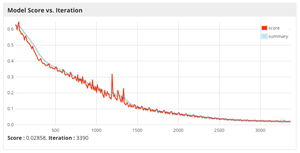

Deeplearning4j has a built-in `MultipleEpochsIterator` that automatically handles multiple epochs of training. Alternatively, if you instead want to handle per-epoch events you can either use an `EarlyStoppingGraphTrainer` which listens for scoring events, or wrap `net.fit()` in a for-loop yourself.

Below, we manually create a for-loop since our iterator requires a more complex `MultiDataSet`. This is because our seq2seq autoencoder uses multiple inputs/outputs.

The autoencoder here has been tuned to converge with an average reconstruction error of approximately 2% when trained for 35+ epochs.

In [26]:
// we will pass our training data to an iterator that can handle multiple epochs of training
val numEpochs = 150

(1 to numEpochs).foreach { i =>
    net.fit(trainIter)
    println(s"Finished epoch $i")
}

### Compare reconstructed outputs

Below we build a loop to visualize just how well our autoencoder is able to reconstruct the original sequences. After forwarding a single example, we score the reconstruction and then compare the original array to the reconstructed array. Note that we need to do some string formatting, otherwise when we try to print the array we will get garbled output - this is actually a reference to the array object in memory.

In [28]:
def arr2Dub(arr: INDArray): Array[Double] = arr.dup().data().asDouble()
val format = new java.text.DecimalFormat("#.##")

testIter.reset()
(0 to 10).foreach{ i =>
    val mds = testIter.next(1)
    val reconstructionError = net.score(mds)
    val output = net.feedForward(mds.getFeatures(), false)
    val feat = arr2Dub(mds.getFeatures(0))
    val orig = feat.map(format.format(_)).mkString(",")
    val recon = arr2Dub(output.get("output")).map(format.format(_)).take(feat.size).mkString(",")
    
    println(s"Reconstruction error for example $i is $reconstructionError")
    println(s"Original array:        $orig")
    println(s"Reconstructed array:   $recon")
}

### Transferring the parameters

Now that the network has been trained, we will extract the encoder from the network. This is so we can construct a new network for exclusive representation encoding.

In [30]:
// use the GraphBuilder when your network is a ComputationGraph
val encoder = new TransferLearning.GraphBuilder(net)
    .setFeatureExtractor("laststep")
    .removeVertexAndConnections("decoder-merge")
    .removeVertexAndConnections("decoder")
    .removeVertexAndConnections("decoder2")
    .removeVertexAndConnections("output")
    .removeVertexAndConnections("dup")
    .addLayer("output", new ActivationLayer.Builder().activation(Activation.IDENTITY).build(), "laststep")
    .setOutputs("output")
    .setInputs("encoderInput")
    .setInputTypes(InputType.recurrent(2))
    .build()
    
// grab a single batch to test feed forward
val ds = testIter.next(1)
val embedding = encoder.feedForward(ds.getFeatures(0), false)
val shape = embedding.get("output").shape().mkString(",")
val dsFeat = arr2Dub(ds.getFeatures(0))
val dsOrig = dsFeat.map(format.format(_)).mkString(",")
val rep = arr2Dub(embedding.get("output")).map(format.format(_)).take(dsFeat.size).mkString(",")

println(s"Compressed shape:       $shape")
println(s"Original array:        $dsOrig")
println(s"Compressed array:      $rep")

### Clustering the output

Homestretch! We're now able to take the compressed representations of our trajectories and start to cluster them together. As mentioned earlier, a non-K clustering algorithm is preferable.

The [Smile Scala library](https://haifengl.github.io/smile/clustering.html#g-means) has a number of clustering methods already available and we'll be using it for grouping our trajectories.

In [32]:
// first we need to grab our representations
// in a "real world" scenario we'd want something more elegant that preserves our MMSIs
val dataset = scala.collection.mutable.ListBuffer.empty[Array[Double]]
while(testIter.hasNext()) {
    val ds = testIter.next(1)
    val rep = encoder.feedForward(ds.getFeatures(0), false)
    dataset += rep.get("output").dup.data.asDouble
}

In [33]:
import smile.clustering.GMeans

val maxClusterNumber = 100
val gmeans = new GMeans(dataset, maxClusterNumber)

### What's next?

- Check out all of our tutorials available [on Github](https://github.com/deeplearning4j/dl4j-examples/tree/master/tutorials). Notebooks are numbered for easy following.